# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 3 - Forecasting Bike Sharing Usage


<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Classroom.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [2]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
from IPython.core.display import HTML
def css_styling():
    styles = open("style/cs109.css", "r").read()
    return HTML(styles)
css_styling()

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. You will prepare a small report for them.

The hourly demand information would be useful in planning the number of bikes that need to be available in the system on any given hour of the day, and also in monitoring traffic in the city. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on attributes about the hour and the day. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will add some features that will help us with the analysis and then separate it into training and test sets. Each row in this file contains 12 attributes and each entry represents one hour of a 24-hour day with its weather, etc, and the number of rental rides for that day divided in categories according to if they were made by registered or casual riders. Those attributes are the following:

- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Explore how Bike Ridership varies with Hour of the Day </b> </div>

#### Learn your Domain and Perform a bit of Feature Engineering

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011 and 1 for 2012.
- `month` with 1 through 12, with 1 denoting Jan. 
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

**1.4** Use visualization to inspect and comment on how **casual** rentals and **registered** rentals vary with the `hour`. 

**1.5** Use the variable `holiday` to show how **holidays** affect the relationship in question 1.4.  What do you observe? 

**1.6** Use visualization to show how **weather** affects **casual** and **registered** rentals. What do you observe? 

### Answers

#### 1.1 Load the dataset from the csv file  ...

In [4]:
bikes_df = pd.read_csv('data/BSS_hour_raw.csv')
print(bikes_df.shape)
print(bikes_df.info())
bikes_df.describe()

(17379, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   hour        17379 non-null  int64  
 3   holiday     17379 non-null  int64  
 4   weekday     17379 non-null  int64  
 5   workingday  17379 non-null  int64  
 6   weather     17379 non-null  int64  
 7   temp        17379 non-null  float64
 8   atemp       17379 non-null  float64
 9   hum         17379 non-null  float64
 10  windspeed   17379 non-null  float64
 11  casual      17379 non-null  int64  
 12  registered  17379 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 1.7+ MB
None


,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


<HR>
All the data types make sense, except for dteday, which is an object and should be a datetime variable.
    
We don't have any problem with missing data.
    
The temperature ranges (min and max) doesn't seem to make sense since we're told that `temp` and `atemp` was measured in Celcius and the value is in the interval $[0,1]$; Maybe it's normalized.
<HR>

#### 1.2 Notice that the variable in column ....

In [5]:
bikes_df['dteday']=bikes_df.dteday.map(pd.to_datetime)
bikes_df.dtypes

dteday        datetime64[ns]
season                 int64
hour                   int64
holiday                int64
weekday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
dtype: object

#### 1.3 Create three new columns ...

In [6]:
def get_year(date):
    if date.year ==2011:
        return 0
    elif date.year == 2012:
        return 1
bikes_df['year'] = bikes_df.dteday.map(get_year)
bikes_df['month'] = bikes_df.dteday.map(lambda x: x.month)
bikes_df['counts'] = bikes_df.casual+bikes_df.registered
bikes_df.head(-5)

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,year,month,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,0,1,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,0,1,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,0,1,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,0,1,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17369,2012-12-31,1,14,0,1,1,2,0.28,0.2727,0.45,0.2239,62,185,1,12,247
17370,2012-12-31,1,15,0,1,1,2,0.28,0.2879,0.45,0.1343,69,246,1,12,315
17371,2012-12-31,1,16,0,1,1,2,0.26,0.2576,0.48,0.1940,30,184,1,12,214
17372,2012-12-31,1,17,0,1,1,2,0.26,0.2879,0.48,0.0896,14,150,1,12,164


#### 1.4 Use visualization to inspect and comment on how casual rentals and registered rentals vary with the hour. 

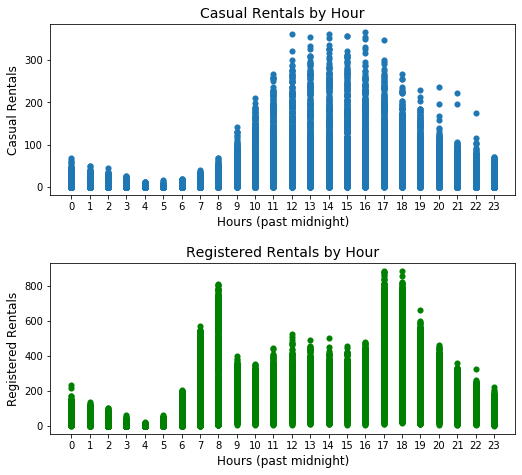

In [7]:
fig, ax = plt.subplots(2,1,figsize=(8,7))
ax[0].scatter(bikes_df.hour,bikes_df.casual,lw=0.1)
ax[0].set_title("Casual Rentals by Hour",fontsize=14)
ax[0].set_xlabel("Hours (past midnight)",fontsize=12)
ax[0].set_ylabel("Casual Rentals",fontsize=12)
# ax[0].grid(True,alpha=0.75,ls="--")
ax[0].set_xticks(np.arange(0,24))
fig.tight_layout(pad=3.0)
ax[1].scatter(bikes_df.hour,bikes_df.registered,lw=0.1,color='green')
ax[1].set_title("Registered Rentals by Hour",fontsize=14)
ax[1].set_xlabel("Hours (past midnight)",fontsize=12)
ax[1].set_ylabel("Registered Rentals",fontsize=12)
ax[1].set_xticks(np.arange(0,24));
# ax[1].grid(True,alpha=0.75,ls="--")


<HR>
    
    As expected both casual and registered rentals are very low between midnight and 5 AM.

    In the morning, as people start to wake up and going to work/school we see an increase in both plots, but a stronger one with registered rentals, especially between 6 AM and 7 AM.
    
    From 8 AM to 4 PM, the registered rentals stay constant, but the casual rides increases. 
    
    After 4 PM we see a sudden increase in registered rentals, maybe people getting back from work/school to home. Casual rentals decrease since this time until midnight. The registered starts the decreasing trend after 6 PM.
    
<HR>

#### 1.5 Use the variable holiday to show how holidays affect the relationship in question 1.4. What do you observe?

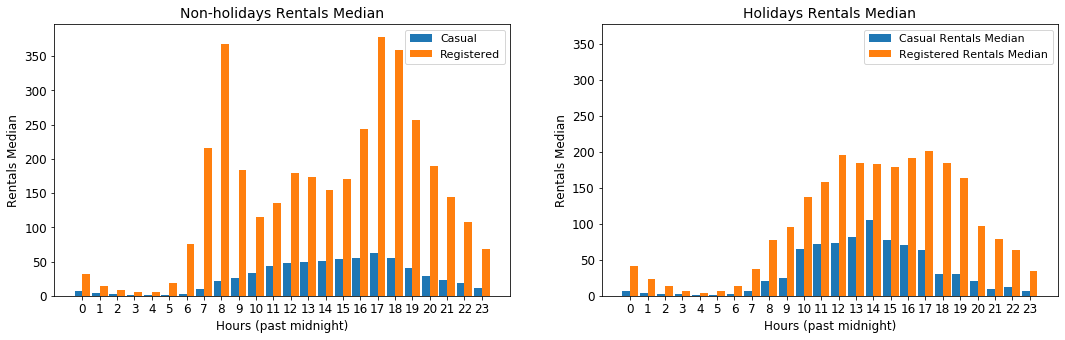

In [8]:
holidays = bikes_df[bikes_df.holiday == 1].groupby('hour').agg({'casual':np.median,'registered':np.median})
non_holidays = bikes_df[bikes_df.holiday == 0].groupby('hour').agg({'casual':np.median,'registered':np.median})
fig,ax  = plt.subplots(1,2,figsize=(18,5))
width = 0.45
ax[1].bar(holidays.index-width/2,holidays.casual,width,label = "Casual Rentals Median")
ax[1].bar(holidays.index+width/2,holidays.registered,width,label = "Registered Rentals Median")
ax[1].set_title("Holidays Rentals Median",fontsize = 14)
ax[1].set_xlabel("Hours (past midnight)",fontsize=12)
ax[1].set_ylabel("Rentals Median",fontsize=12)
ax[1].legend(loc='best',fontsize=11)
ax[1].tick_params(labelsize=12)
ax[1].set_xticks(holidays.index)
ax[1].set_ylim(0,max(non_holidays.registered))

ax[0].bar(non_holidays.index-width/2,non_holidays.casual,width,label = "Casual")
ax[0].bar(non_holidays.index+width/2,non_holidays.registered,width,label = "Registered")
ax[0].set_title("Non-holidays Rentals Median",fontsize = 14)
ax[0].set_xlabel("Hours (past midnight)",fontsize=12)
ax[0].set_ylabel("Rentals Median",fontsize=12)
ax[0].legend(loc='best',fontsize=11)
ax[0].tick_params(labelsize=12)
ax[0].set_xticks(holidays.index);

<HR>
    

    Now we've plotted the median of rentals count instead of scattering all the data. In the left plot, we have the non-holiday rentals; the patterns are very similar to what we already observer at 1.4.

    In the right, we have the Holiday Rentals plot. The spikes we had in registered rentals, in the morning and early afternoon are gone since people don't need to go to work/school on holidays
    
    We see more casual riders in holidays (comparing to non-holidays), and the rentals start to increase after 9 AM, stay constant, and decreases after 5 PM. The registered ones, follow the same pattern but with more absolut rentals. 
  <BR>
<HR>

#### 1.6  Use visualization to show how weather affects casual and registered rentals. What do you observe?

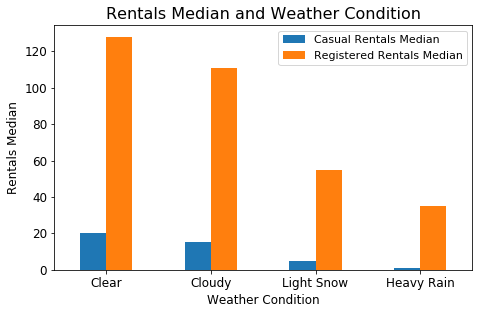

In [9]:
f, ax = plt.subplots(1,1,figsize=(7.5,4.5))
weather=bikes_df.groupby(['weather']).agg({'casual':np.median,'registered':np.median})
weather.rename(columns={'casual':"Casual Rentals Median",'registered':'Registered Rentals Median'}, index={1:'Clear',2:'Cloudy',3:'Light Snow',4:'Heavy Rain'},inplace=True)
ax.set_title("Rentals Median and Weather Condition",fontsize=16)

weather.plot(kind='bar',ax=ax);
ax.legend(loc='best',fontsize=11)
ax.tick_params(labelsize=12)
ax.set_ylabel('Rentals Median',fontsize=12)
ax.set_xlabel('Weather Condition',fontsize=12)
ax.tick_params(axis='x', labelrotation=0)
plt.show()


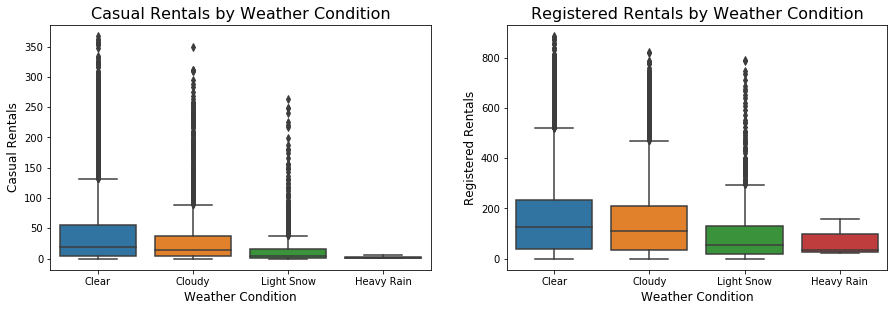

In [10]:
bk2=bikes_df.copy()
bk2.weather=bk2.weather.map({1:'Clear',2:'Cloudy',3:'Light Snow',4:'Heavy Rain'})
f2,(ax1,ax2) = plt.subplots(1,2,figsize=(15,4.5))
sns.boxplot(x='weather',y='casual',data=bk2,ax=ax1)
sns.boxplot(x='weather',y='registered',data=bk2,ax=ax2)
ax1.set_ylabel('Casual Rentals',fontsize=12)
ax1.set_xlabel('Weather Condition',fontsize=12)
ax1.set_title("Casual Rentals by Weather Condition",fontsize=16)
ax2.set_ylabel('Registered Rentals',fontsize=12)
ax2.set_xlabel('Weather Condition',fontsize=12)
ax2.set_title("Registered Rentals by Weather Condition",fontsize=16);

<HR>
The first plot titled "Rentals Median and Weather Condition", shows us a decreasing trend in rentals as weather condition becomes worse. An interesting thing is that on heavy rain days we almost don't have casual rides and just a few registered ones. A reasonable explanation is that the few registered users could be people who had to go to work or school independently of the weather scenario, and the casual riders stays protected at their homes. 
    
We've also plotted two boxplots, which shows that, no only the median decreases, but the distribution as a whole.
<HR>

<div class='exercise'> <b> Question 2: Explore Seasonality on Bike Ridership. </b></div>

#### Seasonality and weather

Now let's examine the effect of weather and time of the year. For example, you want to see how ridership varies with season of the year. 

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being **ONE** day:

- `dteday`, the timestamp for that day (fine to set to noon or any other time)
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals

Name this dataframe `bikes_by_day` and use it for all of Question 2.

**2.2** How does **season** affect the number of bike rentals for **casual riders** or **registered riders** per day? Use the variable `season` for this question. Comment on your observations. 

**2.3** What percentage of rentals are made by casual riders or registered riders for each day of the week? Comment on any patterns you see and give a possible explanation.

**2.4** How is the **distribution of total number of bike rentals** different for sunny days vs cloudy days?

**2.5** Visualize how the **total number of rides** per day varies with the **season**. Do you see any **outliers**? (We define an outlier as a value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. This is the same rule used by pyplot's boxplot function). If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or an important event.

#### HINT
- Use .copy() when creating the new dataframe, so you leave the original untouched. We will come back to it later.
- Use .groupby() to creat the new dataframe. You will have to make some choice on how to aggregate the variables.

### Answers

#### 2.1 Make a new dataframe with the following subset ...

In [11]:
# Reference: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

bikes_by_day=bikes_df.groupby(['dteday']).agg(
    {'weekday':np.min,
     'weather':np.max,
     'season':np.min,
     'temp':np.mean,
     'atemp':np.mean,
     'windspeed':np.mean,
    'hum':np.mean,
    'casual':np.sum,
    'registered':np.sum,
    'counts':np.sum})
bikes_by_day.insert(0,'dteday',bikes_by_day.index)
bikes_by_day=bikes_by_day.set_index(np.arange(0,731))
bikes_by_day

,dteday,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
0,2011-01-01,6,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
1,2011-01-02,0,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2,2011-01-03,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
3,2011-01-04,2,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
4,2011-01-05,3,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...
726,2012-12-27,4,3,1,0.254167,0.226642,0.350133,0.652917,247,1867,2114
727,2012-12-28,5,2,1,0.253333,0.255046,0.155471,0.590000,644,2451,3095
728,2012-12-29,6,3,1,0.253333,0.242400,0.124383,0.752917,159,1182,1341
729,2012-12-30,0,2,1,0.255833,0.231700,0.350754,0.483333,364,1432,1796


#### 2.2 How does season affect the number of bike ...

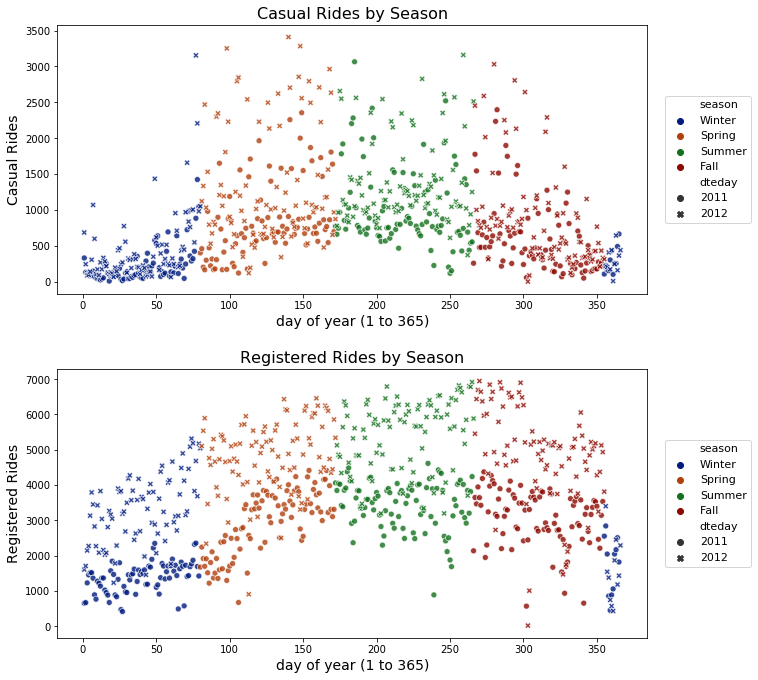

In [12]:
#Reference: 
#https://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels-using-matplotlib
#https://stackoverflow.com/questions/53733755/how-to-move-legend-to-outside-of-a-seaborn-scatterplot/53737271
f, (ax,ax1) = plt.subplots(2,1, figsize=(10, 10))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

bikes_by_day=bikes_by_day.replace({'season':{1:'Winter',2:'Spring',3:'Summer',4:'Fall'}})
sns.scatterplot(bikes_by_day['dteday'].apply(lambda x:x.dayofyear),
                'casual', data=bikes_by_day, hue='season',
                style=bikes_by_day['dteday'].apply(lambda x:x.year),
                palette='dark',alpha=0.8,ax=ax)
ax.set_title('Casual Rides by Season',fontsize=16)
ax.set_xlabel('day of year (1 to 365)',fontsize=14)
ax.set_ylabel('Casual Rides',fontsize=14)
f.tight_layout(pad=3.0)
sns.scatterplot(bikes_by_day['dteday'].apply(lambda x:x.dayofyear),
                'registered', data=bikes_by_day, hue='season',
                style=bikes_by_day['dteday'].apply(lambda x:x.year),
                palette='dark',alpha=0.8,ax=ax1)
ax1.set_title('Registered Rides by Season',fontsize=16)
ax1.set_xlabel('day of year (1 to 365)',fontsize=14)
ax1.set_ylabel('Registered Rides',fontsize=14);
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1)
ax1.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1);


In [13]:
bikes_by_day=bikes_by_day.replace({'season':{'Winter':1,'Spring':2,'Summer':3,'Fall':4}})

<HR>

    We can see on Casual Rides plot that in the Winter (blue) we have the lowest numbers
    of rentals. An explanation would be the cold weather conditions that aren't properly
    to exercise outside or general rides made by casual users. 
    
    As the Spring (orange) comes, the number starts do grow, and when Summer (green) 
    arrives we have the largest rides counts. The Fall (red) brings a decreasing trend
    which persists until the low number of Winter and we get back to the same cycle.
    
    The Registered Rides plot follows the same trend.
    
    An interesting observation is that on both plots, it seems to have more riders 
    made in 2012 than in 2011. Maybe it's because the company had grown its program 
    and gained more users in a year-over-year comparison.
    
<HR>

#### 2.3 What percentage of rentals are made by casual riders or registered riders ...

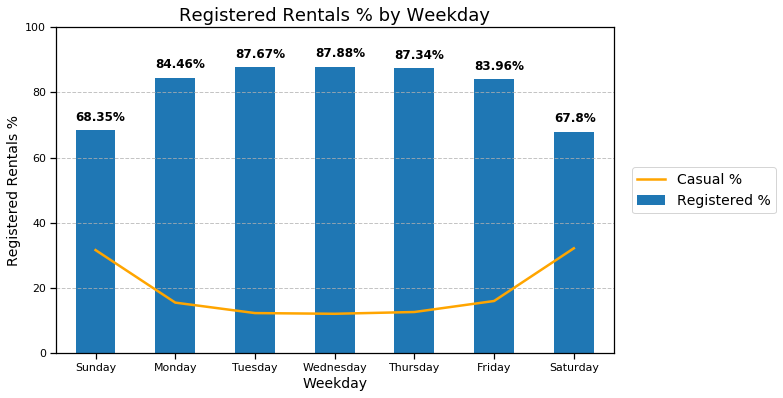

In [14]:
# your code here
f,ax= plt.subplots(1,1,figsize=(10,6))
days = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
weekday = bikes_by_day.groupby('weekday').agg({'casual':np.sum,'registered':np.sum,'counts':np.sum})


weekday.index=weekday.index.map(days)
weekday['Registered %']=weekday.registered*100/weekday.counts
weekday['Casual %']=weekday.casual*100/weekday.counts
weekday[['Registered %']].plot.bar(ax=ax)
weekday['Casual %'].plot.line(ax=ax,color='orange')
ax.set_title("Registered Rentals % by Weekday",fontsize=18)
ax.set_xlabel("Weekday",fontsize=14)
ax.set_ylabel("Registered Rentals %",fontsize=14)
ax.set_ylim(0,100)
ax.grid(True,alpha=0.75,ls='--',axis='y')
plt.tick_params(axis='x', labelrotation=0)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1,fontsize=14)
for i, v in enumerate(weekday['Registered %']):
    ax.text(i-.25,v + 3, str(round(v,2))+"%", color='black', fontweight='bold')
plt.show()


<HR>
    
    
    From Monday to Friday, the shared is dominated by registered users which makes more than 80% of the rentals.
    
    But on Saturday and on Sunday these numbers fall to around 68% and casual rides increases.
    
    An explanation, would be that the profile of registered users tends to be those people who need the bikes every working day from going to school or work, and casual riders are those who use the bikes for more recreational activities such as cycling at parks, or around the city to exercise; Maybe, that's why casual rides share increases on weekends because the registered who use for work are not using it.
<HR>

#### 2.4 How is the distribution of total number of bike rentals different ...

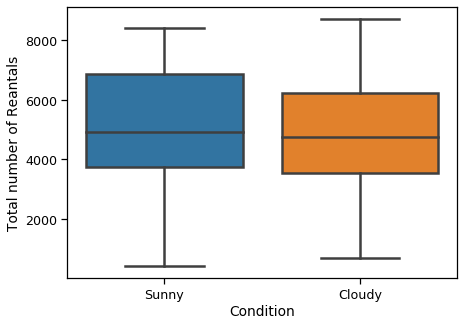

In [15]:
# Let's use Sunny days as weather = 1, and Cloudy days as weather = 2
sunny = bikes_by_day.copy()
sunny.insert(0,'Condition',sunny.weather.map(lambda x: 'Sunny' if x==1 else 'Cloudy' if x==2 else None))

plt.figure(figsize=(7,5))
sns.set_context("notebook", font_scale=1.15, rc={"lines.linewidth": 2.5})
sns.boxplot(x='Condition',y='counts',data=sunny);
plt.ylabel("Total number of Reantals");


<HR>
As we saw before on the weather plot, we can see here that on sunny days we tend to have more riders since the median and the IQR are higher.
<HR>

#### 2.5 Visualize how the total number of rides per day ...

,dteday,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts,is_outlier
441,2012-03-17,6,2,Winter,0.514167,0.505046,0.110704,0.755833,3155,4681,7836,True
667,2012-10-29,1,3,Fall,0.440000,0.439400,0.358200,0.880000,2,20,22,True


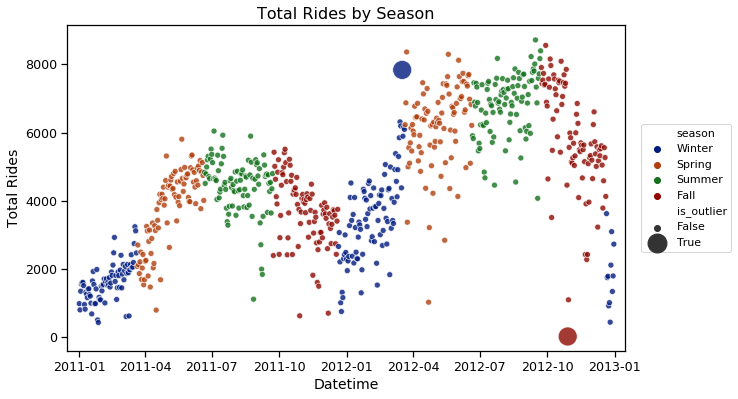

In [16]:
#Preparing the dataframe
season_df=bikes_by_day.replace({'season':{1:'Winter',2:'Spring',3:'Summer',4:'Fall'}})
def q25(col):
    return col.quantile(.25)
def q75(col):
    return col.quantile(.75)
def iqr(col):
    return col.quantile(.75)-col.quantile(.25)

iqr_df= season_df.groupby('season').agg({'counts':[q25,q75,iqr]})#we're gonna calculate the outliers by season
def is_outlier(season,counts):
    IQR = iqr_df.loc[season].set_index(np.arange(0,731))
    return (counts<IQR.iloc[:,0]-1.5*IQR.iloc[:,2]) | (counts>IQR.iloc[:,1]+1.5*IQR.iloc[:,2])

season_df['is_outlier']=is_outlier(season_df['season'],season_df['counts'])

#Plotting
f, ax = plt.subplots(1,1, figsize=(10, 6))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

sns.scatterplot(season_df['dteday'],
                'counts', data=season_df, hue='season',
                size='is_outlier',sizes=(360,36),
                palette='dark',alpha=0.8,ax=ax)
ax.set_title('Total Rides by Season',fontsize=16)
ax.set_xlabel('Datetime',fontsize=14)
ax.set_ylabel('Total Rides',fontsize=14);
x0 = pd.to_datetime('20101215', format='%Y%m%d', errors='ignore')
x1 = pd.to_datetime('20130115', format='%Y%m%d', errors='ignore')
ax.set_xlim(x0,x1)
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1);

season_df[season_df.is_outlier==1]

<HR>

    
    The Outlier on 29 October 2012 (Just 22 rides) could be explained by the following
    news article title:
    
    "Washington DC shuts down in preparation for Hurricane Sandy"
    
    by The Guardian, October 29th, 2012 
    (https://www.theguardian.com/world/2012/oct/29/washington-dc-shutdown-hurricane-sandy)
    
    A hurricane is a very reasonable explanation for the low value.
    
    The outlier on 17 March 2012 could be explained by the Saint Patrick's Holiday 
    in the U.S.A, people are free from work/school to ride bikes with their friends 
    or family. Another fact is that, although Washington D.C was technically in winter, 
    that month was marked by record-breaking warmth as follow the article:
    
    https://earthsky.org/earth/record-breaking-warmth-across-the-united-states-in-march-20
    
<HR>

<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

**3.1** Visualize and describe inter-dependencies among the following variables: `weekday`, `season`, `month`,`weather`, `temp`, `atemp`, `hum`, `windspeed`, `casual`,`registered`, `counts`. Note and comment on any strongly related variables.

**3.2** Convert the categorical attributes into multiple binary attributes using **one-hot encoding**. 


**3.3** Split the initial `bikes_df` dataset (with hourly data about rentals) into train and test sets. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. We ask you to create your train and test sets, but for consistency and easy checking we ask that, for the rest of this problem set, you use the train and test set provided in the question below.

**3.4** Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively. After checking your train and test datasets for accuracy, remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis. Also, remove any predictors that would make predicting the `count` trivial.

**3.5** Calculate the **Pearson correlation** coefficients between all the features. Visualize the matrix using a heatmap. Which predictors have a positive correlation with the number of bike rentals? For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Identify pairs of predictors with collinearity >0.7.

#### Hints: 
- You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.



#### Answers

#### 3.1 Visualize and describe inter-dependencies  ... 

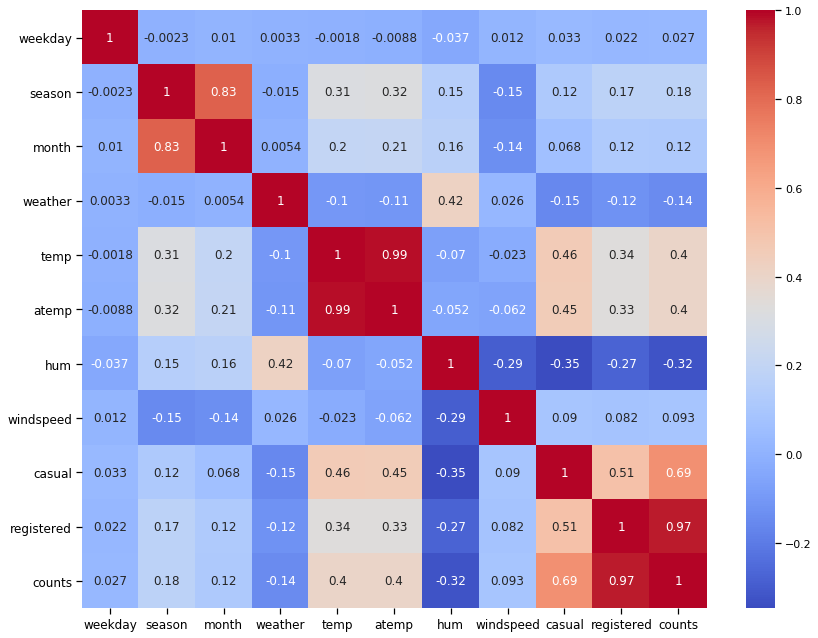

In [17]:
#Reference: https://towardsdatascience.com/visualizing-statistical-plots-with-seaborn-6b6e60ce5e71
corr_df=bikes_df[
    ['weekday','season','month',
     'weather','temp','atemp','hum',
     'windspeed','casual','registered','counts']]
f,ax = plt.subplots(1,1,figsize=(14,11))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
ax.tick_params(labelsize=12)
sns.heatmap(corr_df.corr(), cmap = 'coolwarm', annot = True);

<HR>

    
    We can observate the some strongly correlated variables:
    
    - temp and atemp (0.99)
    - month and season (0.93)
    - registered and counts (0.97)
    
    season is a obviously direct function of month, and atemp is very dependent of temp.
    
    As we saw on item 2.3 the majority of the users are registered ones, so it's gonna have 
    more influence on the counts variable. Notice that casual and counts have a reasonable 
    correlation (0.69) but not so strong as registered/counts.
    
    <HR>

#### 3.2 Convert the categorical attributes  ....

In [18]:
dummies=pd.get_dummies(bikes_df,columns=['weather','month','weekday','season'],drop_first=1).rename(columns=
{'weather_2':'Cloudy','weather_3':'Snow','weather_4':'Storm',
'month_2':'Feb','month_3':'Mar','month_4':'Apr','month_5':'May','month_6':'Jun',
'month_7':'Jul','month_8':'Aug','month_9':'Sep','month_10':'Oct','month_11':'Nov','month_12':'Dec',
'weekday_1':'Mon','weekday_2':'Tue','weekday_3':'Wed','weekday_4':'Thu','weekday_5':'Fri','weekday_6':'Sat',
'season_2':'Spring','season_3':'Summer','season_4':'Fall'})
dummies.columns

Index(['dteday', 'hour', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'year', 'counts', 'Cloudy', 'Snow',
       'Storm', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
       'Nov', 'Dec', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Spring',
       'Summer', 'Fall'],
      dtype='object')

<HR>
Holiday and Workingday variables are already binaries, so we just transformed weather, month, weekday and season.
<HR>

#### 3.3 Split the initial bikes_df dataset...

In [19]:
train, test = train_test_split(dummies, test_size = 0.2, stratify=bikes_df['month'])
train.shape,test.shape

((13903, 35), (3476, 35))

#### 3.4  Read `data/BSS_train.csv` and `data/BSS_test.csv` into ...

In [20]:
BSS_train = pd.read_csv('data/BSS_train.csv').drop("Unnamed: 0",axis=1)
BSS_test = pd.read_csv('data/BSS_test.csv').drop("Unnamed: 0",axis=1)
print(BSS_train.shape, BSS_test.shape)
print("\nTrain data month proportions\n",BSS_train.iloc[:,15:26].mean(),
      "\nTest data month proportions\n",BSS_test.iloc[:,15:26].mean())

(13903, 35) (3476, 35)

Train data month proportions
 Feb     0.077178
Mar     0.084730
Apr     0.082716
May     0.085593
Jun     0.082860
Jul     0.085593
Aug     0.084874
Sept    0.082716
Oct     0.083507
Nov     0.082716
Dec     0.085305
dtype: float64 
Test data month proportions
 Feb     0.077100
Mar     0.084868
Apr     0.082566
May     0.085731
Jun     0.082854
Jul     0.085731
Aug     0.084868
Sept    0.082566
Oct     0.083429
Nov     0.082566
Dec     0.085443
dtype: float64


In [21]:
counts_train = BSS_train['counts']
counts_test = BSS_test['counts']
BSS_train.drop(['dteday','casual','registered','counts'],axis=1,inplace=True)
BSS_test.drop(['dteday','casual','registered','counts'],axis=1,inplace=True)
BSS_test.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

<HR>
     
    Comparing the month proportions from train and test sets, we can see pretty close values, so stratifying worked fine.
    We removed the casual and registered columns because it would make the predicting counts trivial.
<HR>

#### 3.5 Calculate the **Pearson correlation** ....

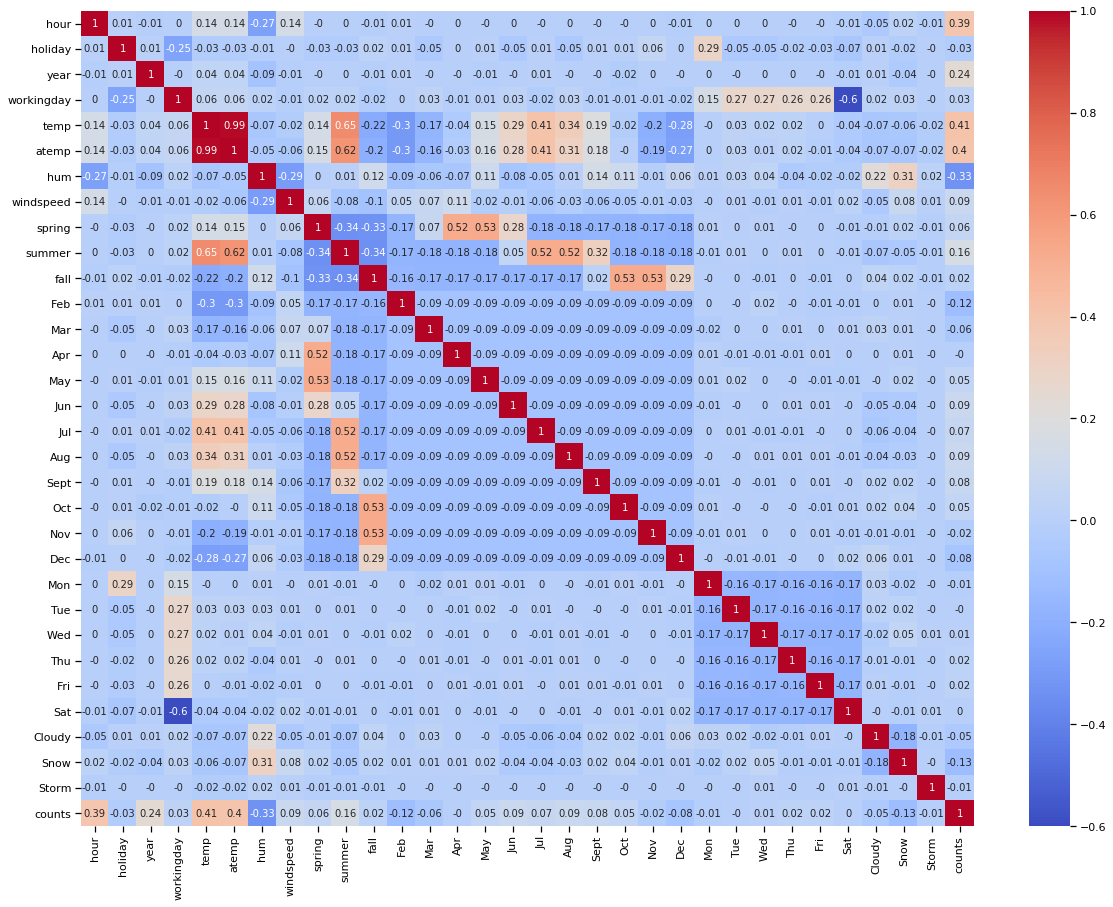

In [22]:
#References: https://github.com/mwaskom/seaborn/issues/430
#            https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

f,ax = plt.subplots(1,1,figsize=(20,15))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
sns.heatmap(pd.concat([BSS_train, counts_train], axis=1, sort=False).corr().round(2),
            cmap='coolwarm',annot = True,annot_kws={"size": 10});

<HR>

    Variables that have positive correlation with the number of bike rentals:
    - hour (0.39)            - May (0.05)
    - year (0.24)            - Jun (0.09)
    - temp (0.41)            - Jul (0.07)
    - atemp (0.4)            - Aug (0.09)
    - windspeed (0.09)       - Sept (0.08)
    - spring (0.06)          - Oct (0.05)
    - summer (0.16)          - Wed (0.01)
    - fall (0.02)            - Thu (0.02)
                             - Fri (0.02)
    
    Pairs with collinearity > 0.7:
    - temp and atemp
    
    Some interesting pairs:
    
    - temp and summer (0.65)
        This correlation makes sense since in the summer we have higher temperatures.
    - workingday and Sat (-0.6)
        It also makes sense because Saturday isn't a workingday.
<HR>

<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms), and report its $R^2$ score on the train and test sets.


**4.2** Find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value < 0.05). Comment on the results.


**4.3** Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is slightly different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms? 

### Answers
#### 4.1 Use statsmodels to fit a ... 


In [23]:
x_train_constant = sm.add_constant(BSS_train)
linear_reg = OLS(counts_train,x_train_constant).fit()
train_R2 = linear_reg.rsquared
y = counts_test.copy()
num = np.sum((sm.add_constant(BSS_test).dot(linear_reg.params) - y)**2)
den = np.sum((np.mean(y) - y)**2)
test_R2 = 1 - num/den
print("Train R2: {}\nTest R2:  {}".format(train_R2,test_R2))

Train R2: 0.4065387827969086
Test R2:  0.40638554757102263



The train and test $R^2$ scores are very close ($\approx 0,41$), the difference appear in the fourth decimal place and following.


#### 4.2 Find out which of estimated coefficients ...

In [25]:
print(linear_reg.pvalues[linear_reg.pvalues<0.05])
linear_reg.summary()

const          1.470264e-02
hour           0.000000e+00
holiday        6.095043e-03
year          6.205883e-218
workingday     3.905740e-05
temp           4.767468e-14
hum           2.797780e-149
windspeed      3.628163e-02
spring         6.082058e-09
summer         7.609902e-04
fall           6.106365e-20
Apr            2.640964e-05
May            1.592599e-03
Jun            8.447047e-10
Jul            1.110753e-14
Aug            5.685359e-07
Nov            6.619949e-03
Sat            6.490550e-04
Cloudy         1.926802e-02
Snow           4.454966e-09
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     316.8
Date:                Mon, 03 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:18:35   Log-Likelihood:                -88306.
No. Observations:               13903   AIC:                         1.767e+05
Df Residuals:                   13872   BIC:                         1.769e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.0830      8.641     -2.440      0.015     -38.020      -4.146
hour           7.2214      0.184     39.144      0.000       6.860       7.583
holiday      -18.0958      6.597     -2.743      0.006     -31.027      -5.165
year          76.3519      2.380     32.084      0.000      71.687      81.017
workingday    11.3178      2.751      4.114      0.000       5.926      16.710
temp         333.2482     44.162      7.546      0.000     246.684     419.812
atemp         74.6312     46.207      1.615      0.106     -15.940     165.202
hum         -205.4959      7.801    -26.343      0.000    -220.786    -190.205
windspeed     22.5168     10.753      2.094      0.036       1.439      43.595
spring        43.1541      7.417      5.818      0.000      28.615      57.693
summer        29.5426      8.773      3.367      0.001      12.346      46.739
fall          68.5953      7.492      9.156      0.000      53.911      83.280
Feb           -7.6430      5.966     -1.281      0.200     -19.336       4.050
Mar          -11.6737      6.665     -1.752      0.080     -24.737       1.390
Apr          -41.5244      9.878     -4.204      0.000     -60.886     -22.163
May          -33.2927     10.543     -3.158      0.002     -53.958     -12.628
Jun          -65.8039     10.716     -6.141      0.000     -86.809     -44.799
Jul          -93.4805     12.086     -7.734      0.000    -117.171     -69.789
Aug          -59.2081     11.832     -5.004      0.000     -82.401     -36.015
Sept         -16.0517     10.575     -1.518      0.129     -36.780       4.676
Oct          -16.1602      9.865     -1.638      0.101     -35.497       3.177
Nov          -25.8732      9.527     -2.716      0.007     -44.547      -7.199
Dec          -10.2043      7.614     -1.340      0.180     -25.128       4.719
Mon           -2.6601      2.978     -0.893      0.372      -8.498       3.177
Tue           -6.1425      3.208     -1.915      0.056     -12.430       0.145
Wed            2.2964      3.183      0.721      0.471      -3.943       8.536
Thu           -3.1611      3.185     -0.993      0.321      -9.404       3.082
Fri            2.8892      3.186      0.907      0.364      -3.355       9.133
Sat           14.9459      4.382      3.411      0.001       6.357      23.535
Cloudy         6.7868      2.900      2.341      0.019       1.103      12.470
Snow         -28.2859      4.819     -5.870      0.000     -37.731     -18.841
Storm         42.3569     98.377      0.431      0.667    -150.475     235.189
==============================================================================
Omnibus:                     2831.359   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5657.789
Skew:                           1.224   Prob(JB):                         0.00
Ku

As shown above, the following coefficients that are statistically significant with p-value < 0.05:

- const
- hour, holiday, year 
- workingday
- temp, hum. windspeed
- spring, summer, fall
- months from Apr to Aug
- Nov
- Sat
- Cloudy, Snow

According to the reference, the p-value < 0.05 indicates that is unlikely to get such a substantial association between the above predictors and the response variable due to chance.


Reference: 

https://harvard-iacs.github.io/2019-CS109A/lectures/lecture5/presentation/Lecture5_LinearRegression.pdf

#### 4.3 Make a plot of residuals of the fitted ...

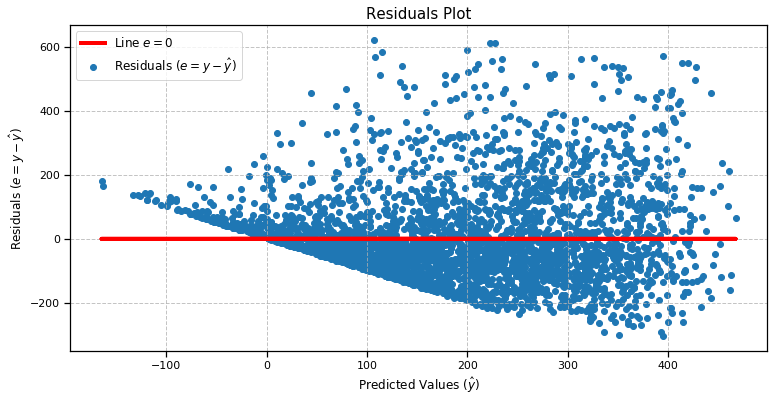

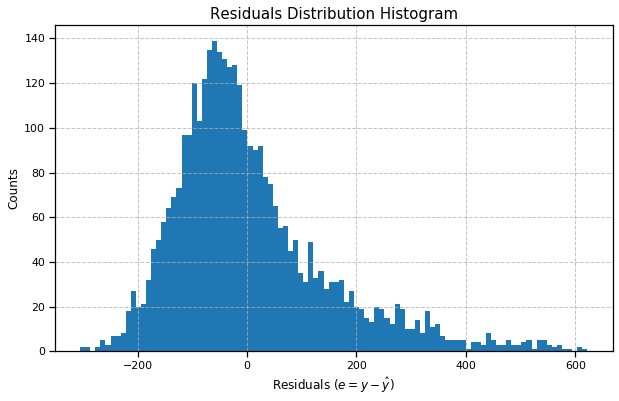

In [24]:
y_hat = sm.add_constant(BSS_test).dot(linear_reg.params)
e = y - y_hat
fig,ax = plt.subplots(1,1,figsize=(12.5,6))
ax.set_title("Residuals Plot",fontsize=15)
ax.set_ylabel(r"Residuals $(e=y-\hat{y})$",fontsize = 12)
ax.set_xlabel(r"Predicted Values ($\hat{y}$)",fontsize = 12)
ax.grid(True,alpha=0.75,ls="--")
ax.scatter(y_hat,e,label = r"Residuals $(e=y-\hat{y})$");
ax.plot(y_hat,np.zeros(y.shape),color='red',lw=4,label = r"Line $e=0$")
ax.legend(loc="best",fontsize=12);

fig,ax2 = plt.subplots(1,1,figsize=(10,6))
ax2.set_title("Residuals Distribution Histogram",fontsize=15)
ax2.set_xlabel(r"Residuals $(e=y-\hat{y})$",fontsize=12)
ax2.set_ylabel("Counts",fontsize=12)
ax2.grid(True,alpha=0.75,ls="--")
ax2.hist(e,bins=100);

As shown in the first plot, there are a lot of residuals far away from 0 (defining far away as $|e|>100$)
This tells us that assuming linearity was not a good choice.

About the variance, we can see that positive errors (when the prediction is lower than tha actual value) have a higher dispersion, and negative errors (prediction greater than actual) have a lower variance. We can also visualize it in the histogram of the residuals, the positive errors have a fatter tail

<div class='exercise'> <b>Question 5: Subset Selection </b> </div>

**5.1** Implement forward step-wise  selection to select a minimal subset of predictors that are related to the response variable: 

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. 

**5.2** Do these methods eliminate one or more of the colinear predictors (if any) identified in Question 3.5?  If so, which ones. Briefly explain (3 or fewer sentences) why you think this may be the case.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Question 4 using all predictors?

### Answers

#### 5.1  Implement forward step-wise ....

In [25]:
best_i = np.inf
predictors = ['const']
remaining_predictors = list(BSS_train.columns)
best_predictors = []
x_train_constant = sm.add_constant(BSS_train)
j = len(BSS_train.columns)
global_BIC = np.inf
BEST_global = None

for k in range(0,j):
    local_BIC = np.inf
    best_i = np.inf
    for i, predictor in enumerate(remaining_predictors):
        subset = predictors.copy()
        subset.append(predictor)
        model = OLS(counts_train,x_train_constant[subset]).fit()
        if model.bic < local_BIC:
            best_model=model
            best_predictors=subset
            local_BIC = model.bic
            best_i = i
    predictors.append(remaining_predictors[best_i])
    remaining_predictors.pop(best_i)
    if best_model.bic<global_BIC:
        global_BIC=best_model.bic
        BEST_global = best_predictors
print("{} predictors selected: \n{}".format(len(BEST_global)-1,BEST_global[1:]))

11 predictors selected: 
['temp', 'hour', 'year', 'hum', 'fall', 'Jul', 'Snow', 'Aug', 'Jun', 'holiday', 'spring']


#### 5.2 Do these methods eliminate ...

<HR>

    
    The pair temp/atemp, highly correlated in 3.5, was reduced to just temp.
    
    This can be explained by the nature of the BIC measure, which has a term on its 
    formula that penalizes the number of parameters used in the model. So, if temp 
    was already considered to be a good predictor, we won't add correlated predictors.
    The same happened with the summer variable, which had a correlation coefficient 
    with temp equal 0.65
    
<HR>

#### 5.3 In each case, fit linear regression  ...

In [26]:
x=sm.add_constant(BSS_train)
x=x[BEST_global]

x_test = sm.add_constant(BSS_test)
x_test = x_test[BEST_global]

fit = OLS(counts_train,x).fit()
test_R2_new = r2_score(counts_test,x_test.dot(fit.params))
print("Question 4 R2: {}\nNew Test R2:   {}".format(test_R2,test_R2_new))

Question 4 R2: 0.40638554757102263
New Test R2:   0.40469087705369633


<HR>

    We got a slightly lower R2 test score with fewer predictors. 
    Maybe with polinomial regression we can have better results.
    
<HR>

<div class='exercise'> <b> Question 6: Polynomial Regression </b> </div> 

We will now try to improve the performance of the regression model by including higher-order polynomial terms. 

**6.1** For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a polynomial regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in the previous question? Using a $t$-tests, find out which of the estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

In [27]:
def make_columns(name):
    return [name,name+"_2",name+"_3",name+"_4"]

transformer_4 = PolynomialFeatures(4, include_bias=False)
continuous = ['hour','temp','atemp','hum','windspeed']

def expand(df,columns=continuous,transformer=transformer_4):
    df2 = df.copy().drop(columns,axis=1)
    for pred in columns:
        expanded = transformer.fit_transform(np.array(df[pred]).reshape(-1,1))
        df2 = pd.concat([df2,pd.DataFrame(expanded,columns=make_columns(pred))],axis=1)
    return df2


x_train_expanded = sm.add_constant(expand(BSS_train))
poly_reg = OLS(counts_train,x_train_expanded).fit()
poly_testR2 = r2_score(counts_test,sm.add_constant(expand(BSS_test)).dot(poly_reg.params))
print("Test R2 = {}".format(poly_testR2))
poly_reg.pvalues[poly_reg.pvalues<0.05]

Test R2 = 0.5518725502378892


year           0.000000e+00
workingday     4.344489e-08
spring         5.914269e-10
summer         2.768444e-07
fall           1.700842e-29
Feb            6.660587e-05
Mar            6.803256e-11
Apr            1.197507e-03
May            7.884903e-04
Jun            3.285810e-02
Sept           4.809369e-04
Oct            2.519098e-04
Mon            4.344316e-02
Fri            3.076618e-03
Sat            4.534855e-06
Cloudy         7.230378e-08
Snow           3.365023e-53
hour           1.105382e-02
hour_2         2.515556e-03
hour_4         4.694163e-08
temp_3         1.164024e-02
temp_4         5.519511e-04
hum_2          1.092436e-02
hum_3          3.077076e-03
hum_4          1.897774e-03
windspeed_3    2.378387e-02
windspeed_4    2.873829e-02
dtype: float64

<HR>

    About the R2 score, we got an aproximate value of 0.552, 
    which is better than the previosly found (aproximate 0.406)
    
    The estimated coefficients for the polynomial terms are 
    statistically significant at a significance level of 5%, 
    according to the above summary are:
    
    hour           
    hour_2         
    hour_4         
    temp_3         
    temp_4        
    hum_2          
    hum_3          
    hum_4       
    windspeed_3 
    windspeed_4
<HR>

#  Written Report to the Administrators
<br>

<div class='exercise'> <b> Question 7 </b> </div>

Write a short summary report, intended for the administrators of the company, to address two major points (can be written as two large paragraphs):

1. How to predict ridership well (which variables are important, when is ridership highest/lowest, etc.).

2. Suggestions on how to increase the system revenue (what additional services to provide, when to give discounts, etc.).
 
Include your report below. The report should not be longer than 300 words and should include a maximum of 3 figures. 

In [28]:
#Generating figures
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.scatter(bikes_df.hour,bikes_df.counts,lw=0.1)
ax.set_title("Figure 1 - Total Rentals by Hour",fontsize=14)
ax.set_xlabel("Hours (past midnight)",fontsize=12)
ax.set_ylabel("Total Rentals",fontsize=12)
plt.savefig('fig01.jpg')
plt.close();


season_df=bikes_by_day.replace({'season':{1:'Winter',2:'Spring',3:'Summer',4:'Fall'}})
f, ax = plt.subplots(1,1, figsize=(10, 6))
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

sns.scatterplot(season_df['dteday'],
                'counts', data=season_df, hue='season',
                sizes=36,palette='dark',alpha=0.8,ax=ax)
ax.set_title('Figure 2 - Total Rides by Season',fontsize=16)
ax.set_xlabel('Datetime',fontsize=14)
ax.set_ylabel('Total Rides',fontsize=14);
x0 = pd.to_datetime('20101215', format='%Y%m%d', errors='ignore')
x1 = pd.to_datetime('20130115', format='%Y%m%d', errors='ignore')
ax.set_xlim(x0,x1)
ax.legend(loc='best');
plt.savefig('fig02.jpg')
plt.close()


bk2=bikes_df.copy()
bk2.weather=bk2.weather.map({1:'Clear',2:'Cloudy',3:'Light Snow',4:'Heavy Rain'})
f2,ax1 = plt.subplots(1,1,figsize=(8,5))
sns.boxplot(x='weather',y='counts',data=bk2,ax=ax1)
ax1.set_ylabel('Rentals',fontsize=12)
ax1.set_xlabel('Weather Condition',fontsize=12)
ax1.set_title("Figure 3 - Total Rentals by Weather Condition",fontsize=16);
plt.savefig('fig03.jpg')
plt.close()



#### Predicting ridership
    
In our studies of the data, we could see some features with a relatively strong correlation to the rentals counts. The main ones were climate-related variables: temperature, humidity (with negative corr.), weather condition, and season. Another very important predictor was the hour of the day. Almost all of these features were considered as statistically significant by our regression tests.

As we can see in Figure 1 we have higher ridership in working times, some spikes between 7AM - 8AM, and also between 5PM - 6PM, majorly caused by registered users going to or getting back from work or school. About the weather variables, we have two figures: Figure 2 shows us how the season affects the ridership, we can see that winter is the worst in terms of rentals. Figure 3 shows the relation between weather condition and total rentals, snowy and rainy days decreases the ridership.


![](fig01.jpg) ![](fig02.jpg) ![](fig03.jpg)

#### Revenue Suggestion
     
Based in our studies we can suggest two main approaches to increase the company revenue:
    
- Partnerships
    
As we saw in figure 2 and 3, bad weather conditions and low temperatures (winter) decreases the total number of rentals, and there is little the company can do to increase it. So we propose setting up partnerships with complementary services like bus/metro companies, Uber-like apps, delivery services companies, and everything that might be useful when riding bikes is dangerous or uncomfortable, exclusive costumer discounts in those partners' services may prevent cancels in low season. Also, offering exclusive discounts to those partners clients can bring new bike users.
    
- Discounts
    
The discounts should be focused on converting casual riders to registered ones since registered lifetime value is higher. Our suggestion is to offer discounts on sign-ups in Summer and Spring focusing on weekends and holidays (when we have more casuals). 

In [29]:
# !jupyter nbconvert --execute --to PDF "cs109a_hw3.ipynb"